##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# カスタム訓練：基本

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/customization/custom_training"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/customization/custom_training.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/customization/custom_training.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/customization/custom_training.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

前のチュートリアルでは、機械学習の基本構成ブロックの1つである自動微分について TensorFlow の API を学習しました。
このチュートリアルでは、これまでのチュートリアルに出てきた TensorFlow の基本要素を使って、単純な機械学習を実行します。

TensorFlow には `tf.keras` が含まれています。`tf.keras`は、抽象化により決まり切った記述を削減し、柔軟さと性能を犠牲にすることなく TensorFlow をやさしく使えるようにする、高度なニューラルネットワーク API です。開発には [tf.Keras API](../../guide/keras/overview.ipynb) を使うことを強くおすすめします。しかしながら、この短いチュートリアルでは、しっかりした基礎を身につけていただくために、ニューラルネットワークの訓練についていちから学ぶことにします。

## 設定

In [2]:
import tensorflow as tf

## 変数

TensorFlow のテンソルはイミュータブルでステートレスなオブジェクトです。しかしながら、機械学習モデルには変化する状態が必要です。モデルの訓練が進むにつれて、推論を行うおなじコードが異なる振る舞いをする必要があります（望むべくはより損失の少なくなるように）。この計算が進むにつれて変化する必要がある状態を表現するために、Python が状態を保つプログラミング言語であることを利用することができます。

In [3]:
# Python の状態を使う
x = tf.zeros([10, 10])
x += 2  # これは x = x + 2 と等価で, x の元の値を変えているわけではない

print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


TensorFlow にはステートフルな演算が組み込まれているので、状態を表現するのに低レベルの Python による表現を使うよりは簡単なことがしばしばあります。

`tf.Variable`オブジェクトは値を保持し、何も指示しなくともこの保存された値を読み出します。TensorFlow の変数に保持された値を操作する演算（`tf.assign_sub`, `tf.scatter_update`, など）が用意されています。

In [4]:
v = tf.Variable(1.0)
# Python の `assert` を条件をテストするデバッグ文として使用
assert v.numpy() == 1.0

# `v` に値を再代入
v.assign(3.0)
assert v.numpy() == 3.0

# `v` に TensorFlow の `tf.square()` 演算を適用し再代入
v.assign(tf.square(v))
assert v.numpy() == 9.0


`tf.Variable`を使った計算は、勾配計算の際に自動的にトレースされます。埋め込みを表す変数では、TensorFlow は既定でスパースな更新を行います。これは計算量やメモリ使用量においてより効率的です。

`tf.Variable`はあなたのコードを読む人にその状態の一部がミュータブルであることを示す方法でもあります。

## 線形モデルの適合

これまでに学んだ `Tensor`、 `Variable`、 そして `GradientTape`という概念を使って、簡単なモデルの構築と訓練を行ってみましょう。通常、これには次のようないくつかの手順が含まれます。

1. モデルの定義
2. 損失関数の定義
3. 訓練データの取得
4. 訓練データを使って実行し、"optimizer" を使って変数をデータに適合

ここでは、`f(x) = x * W + b`という簡単な線形モデルを作ります。このモデルには `W` (重み) と `b` (バイアス) の2つの変数があります。十分訓練されたモデルが `W = 3.0` と `b = 2.0` になるようなデータを人工的に作ります。

### モデルの定義

変数と計算をカプセル化する単純なクラスを定義してみましょう。

In [5]:
class Model(object):
  def __init__(self):
    # 重みを `5.0` に、バイアスを  `0.0` に初期化
    # 実際には、これらの値は乱数で初期化するべき（例えば `tf.random.normal` を使って）
    self.W = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.W * x + self.b

model = Model()

assert model(3.0).numpy() == 15.0

### 損失関数の定義

損失関数は、ある入力値に対するモデルの出力がどれだけ出力の目的値に近いかを測るものです。訓練を通じて、この差異を最小化するのがゴールとなります。最小二乗誤差とも呼ばれる L2 損失を使ってみましょう。

In [6]:
def loss(predicted_y, target_y):
  return tf.reduce_mean(tf.square(predicted_y - target_y))

### 訓練データの取得

最初に、入力にランダムなガウス（正規）分布のノイズを加えることで、訓練用データを生成します。

In [7]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

モデルを訓練する前に、モデルの予測値を赤で、訓練データを青でプロットすることで、損失を可視化します。

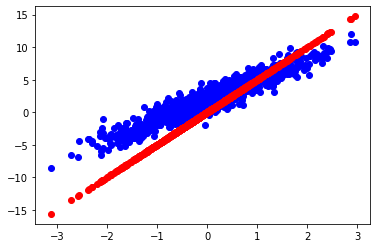

Current loss: 8.123021


In [8]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: %1.6f' % loss(model(inputs), outputs).numpy())

### 訓練ループの定義

ネットワークと訓練データが準備できたところで、損失が少なくなるように、重み変数 (`W`) とバイアス変数 (`b`) を更新するために、[gradient descent （勾配降下法）](https://en.wikipedia.org/wiki/Gradient_descent) を使ってモデルを訓練します。勾配降下法にはさまざまな変種があり、我々の推奨する実装である `tf.train.Optimizer` にも含まれています。しかし、ここでは基本原理から構築するという精神で、自動微分を行う `tf.GradientTape` と、値を減少させる `tf.assign_sub` （これは、`tf.assign` と `tf.sub` の組み合わせですが）の力を借りて、この基本計算を実装してみましょう。

In [9]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dW, db = t.gradient(current_loss, [model.W, model.b])
  model.W.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

最後に、訓練データ全体に対して繰り返し実行し、`W` と `b` がどのように変化するかを見てみましょう。

Epoch  0: W=5.00 b=0.00, loss=8.12302
Epoch  1: W=4.65 b=0.38, loss=5.69242
Epoch  2: W=4.36 b=0.68, loss=4.09065
Epoch  3: W=4.12 b=0.93, loss=3.03475
Epoch  4: W=3.92 b=1.12, loss=2.33847
Epoch  5: W=3.76 b=1.28, loss=1.87918
Epoch  6: W=3.63 b=1.41, loss=1.57614
Epoch  7: W=3.52 b=1.51, loss=1.37612
Epoch  8: W=3.44 b=1.60, loss=1.24407
Epoch  9: W=3.36 b=1.66, loss=1.15686


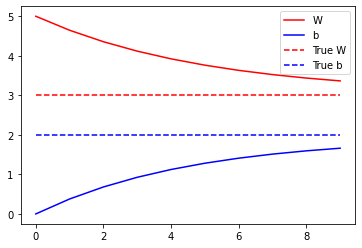

In [10]:
model = Model()

# 後ほどプロットするために、W 値と b 値の履歴を集める
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
  Ws.append(model.W.numpy())
  bs.append(model.b.numpy())
  current_loss = loss(model(inputs), outputs)

  train(model, inputs, outputs, learning_rate=0.1)
  print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

# すべてをプロット
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'True W', 'True b'])
plt.show()


## 次のステップ

このチュートリアルでは `tf.Variable` を使って単純な線形モデルの構築と訓練を行いました。

実際にニューラルネットワークを構築する際には、`tf.keras` のような高レベルな API のほうが遥かに便利です。`tf.keras` は、（「レイヤー」と呼ばれる）高レベルの部品、状態を保存・復元するためのユーティリティ、さまざまな損失関数、さまざまな最適化戦略などを提供しています。詳しく知るには [TensorFlow Keras guide](https://www.tensorflow.org/guide/keras/overview) を参照してください。
